# Model Predictive Control (5) - Closing The Loop

## Table of contents<a class="anchor" id="toc"></a> 

### [Closing the loop](#ThisNotebook)
[The working example (remainder)](#Remainder) / [The Dynamics](#Dynamics) / [The One Step map](#OneStep) / [Formulation of the NLP problem and solver](#FormulatingNLP) / [Definition of the MPC feedback function](#MPCFeedback) / [Open-loop Robustness check](#OLRobustness)

In [35]:
from IPython.display import Image, IFrame
import ipywidgets as wg
import numpy as np
import matplotlib.pyplot as plt
import time
from casadi import MX, vertcat, Function, nlpsol, diag
import matplotlib.pyplot as plt



files_root = "https://www.mazenalamir.fr/MPC/"

width=800

## This Notebook<a class="anchor" id="ThisNotebook"></a>

In the previous notebook entitled 

> Model Predicitive control (4) Optimal control problems solution using the CasaDi framework

It has been shown how to use the Casadi framework in order to formulate and solve the open-loop optimal control problem. The result of the solution step is hopefully the **best sequence of actions**, namely, the one that minimizes the cost function while respecting the constraints. 


Now because of the presence of uncertainties and model mismatch, applying this sequence in **open loop** (without feedback based on the measurement) might lead to undesired drift or even instability of the resulting behaviour. 

That is the reason why the MPC implementation consists in applying the first control in the optimal sequence until the next sampling instant and at the new reached state, formulate the new problem and solve it to get the new best sequence of actions, apply the first control in this new sequence and so on. 

This is what we are going to do in this notebook. More precisely:

1. We shall first reproduce a part of the content of the previous notebook in order to define the simulator and the open-loop optimal control solver.


2. From this solver we shall define a feedback function that implements the principle of MPC recalled above (that extracts the first control in the optimal sequence to apply it to the system).


3. Having the feedback function, we shall simulate the closed-loop under the MPC design under different assumption regarding the model mismatches and the uncertainties. While doing so, we shall compare the behavioir of the system under the open-loop and the closed-loop control in order to enforce the understanding of the role of the feedback in getting the desired behaviour in closed loop.

[back to toc](#toc)

## The working example (remainder)<a class="anchor" id="Remainder"></a>

see previous notebooks for details)

In [4]:
# Do not hesitate to change the width ad the hight in the IFrame Instruction below to fit your window. 
Introduction = files_root+"OptimalControl.pdf"
display(IFrame(Introduction, width=width, height=500))

### The dynamics<a class="anchor" id="Dynamics"></a>

Definition of the ordinary differential equation describing the system to be controlled. Note that compared to the previous notebook, a gain on the action of $u_2$ on the angular acceleration is added in oder to simulate some model discrepancy that would be unknown to the control designer. 

In [5]:
nx = 6 #number of state 
nu = 2 #number of actuators

gam = MX.sym('gam', 1)
epsilon = MX.sym('epsilon', 1)
x = MX.sym('x', nx)
u = MX.sym('u', nu)
xdot = vertcat(x[3], 
               x[4], 
               x[5], 
               - u[0] * np.sin(x[2])+epsilon * u[1] * np.cos(x[2]), 
                u[0] * np.cos(x[2])+epsilon * u[1] * np.sin(x[2])-1, 
                gam * u[1],
              )

# Definition of a map called f taking three argument (x,u,epsilon) and 
# delivering the corresponding state derivative.
# Note that in case many parameter p1, p2, ..., pn are needed, the vertcat command can be used to regroup them 
# in a single parameter vector p=vertcat(p1,p2,...,pn) and the argument list become [x,u,p]

f = Function('f', [x,u, epsilon, gam], [xdot])

[back to toc](#toc)

### The one-step function <a class="anchor" id="OneStep"></a>

Definition of the ordinary differential equation describing the system to be controlled. 

In [6]:
# The prediction horizon in time unit 

T = 4

#number of control intervals (-> control sampling interval = T/N)

N = 20

#number of Runge-Kutta steps per control sampling interval 
# -> The integration sampling time = T/N/M
# M should be sufficiently high to induce sufficiently small sampling integration step
# This is problem-dependent and should be tested off-line 

M = 1
dt = T/N/M

# The initial state 
x0 = MX.sym('x0', nx)
u = MX.sym('u', nu)
epsilon = MX.sym('epsilon', 1)
gam = MX.sym('gam', 1)
x = x0
for i in range(M):
    k1 = f(x,u, epsilon, gam)
    k2 = f(x+0.5*dt*k1, u, epsilon, gam)
    k3 = f(x+0.5*dt*k2, u, epsilon, gam)
    k4 = f(x+dt*k3, u, epsilon, gam)
    x = x + dt/6*(k1+2*(k2+k3)+k4)
    
F = Function('F', [x0,u,epsilon, gam], [x])   

[back to toc](#toc)

### Formulating the optimal control problem <a class="anchor" id="FormulatingNLP"></a>

Definition of the optimal control problem and the associated solver.

In [7]:
# Definition of the weighting matrices to be used in the definition of the cost function 

qvec = [1e3, 1e2, 1e2, 1, 1, 1]
rvec = [1e-1, 1e-1]
qf = 1e1

# Declaration of the initial state and the desired pair

x0 = MX.sym('x0', nx)
xd = MX.sym('xd', nx)
ud = MX.sym('ud', nu)
eps = MX.sym('eps', 1)
gam = MX.sym('gam', 1)

# Define the saturation constraints on the control 
umin = [-1, -2]
umax = [2, 3]

# Define the bound on the derivative of theta

dtheta_dt_max = 0.5

# Declaration of the sequence of control over the prediction horizon 
# the control applied on [k,k+1] will be U[k*nu:(k+1)*nu]

U = MX.sym('U', N * nu)
Umin = np.array([umin] * N).flatten()
Umax = np.array([umax] * N).flatten()

# the cost function and state initialization
J = 0 
xk = x0
# Prepare the state trajectory
X = x0
# The list of constraints and its lower and upper bound

g, lbg, ubg = [], [], []


In [8]:
# simulate SYMBOLICALLY over the prediction horizon
for k in range(N-1):
    
    uk = U[k*nu: (k+1)*nu]
    xk = F(xk, uk, eps, gam)
    X = vertcat(X, xk)
    ex = xk-xd
    eu = uk-ud
    
    # add ex.T (Q * ex) to J 
    for j in range(nx):
        J += qvec[j] * ex[j] * ex[j]
    
    # add eu.T (R * eu) to J 
    for j in range(nu):
        J += rvec[j] * eu[j] * eu[j]
        
    # add the constraint on the derivative of theta 
    
    g += [xk[5]]
    lbg += [-dtheta_dt_max]
    ubg += [+dtheta_dt_max]

    
# add the terminal penalty on the state 
uk = U[(N-1)*nu:]
xk = F(xk, uk, eps, gam)
X  = vertcat(X, xk)
ex = xk-xd
eu = uk-ud

# add ex.T (Qf * ex) to J 
for j in range(nx):
    
    J += qf * qvec[j] * ex[j] * ex[j]
    
# This is a by-product function that will enable the simulation of the resulting solution

simu = Function('simu', [x0, U, eps, gam], [X])

In [9]:
# Declaring the Single-Shooting problem 

prob_SS = {'f':J, 'x':U, 'g':vertcat(*g), 'p':vertcat(x0, xd, ud, eps, gam)}

# declaring the solver 

solver_SS = nlpsol('solver', 'ipopt', prob_SS, {'ipopt':{'max_iter':2000}})

[back to toc](#toc)

### Definition of the MPC feedback <a class="anchor" id="MPCFeedback"></a>

Here begins the new contributions of this notebook. We shall define a function that takes as argument the following items

- The current state of the system
- The target pair of steady state and control ($x_d, u_d$)
- The presumed value of the system's parameters (here $(\epsilon, \gamma)$)
- The initial guess ($U_0$: the initial value of the unknown for the iterations)

The last argument is very important in the context of repetitive solution of the optimal control problem for a relatively close successive values of the state since in this case, the solution of the previously solved problem (one sampling period earlier) should be a very good initialization for the new problem that is defined one sampling period later. Having the possibility to provide the initial guess enables to fully exploit this idea. 

In the MPC literature, this is called a **warm start**!

In [10]:
def MPC(x, xd, ud, eps, gam, U0):
    
    # Solve the problem 
    
    sol = solver_SS(x0=U0, 
                    lbx=Umin, 
                    ubx=Umax, 
                    lbg=lbg, 
                    ubg=ubg, 
                    p=vertcat(x,xd,ud,eps,gam))
    
    # Get the optimal control sequence 
    U_opt = sol['x']
    
    # This map return the optimal sequence of control actions 
    # from which only the first action U_opt[0:nu] is to be used 
    # during the current sampling period.
    
    return U_opt
    

In [11]:
# Let us check this function 

U0 = np.array([[1, 0] for _ in range(N)]).flatten()
x0_ = np.zeros(nx)
xd_ = np.array([0.05, 0.05, 0, 0, 0, 0])
ud_ = np.array([1,0])
eps_ = 0.04
gam_ = 1.0

t0 = time.time()
U_opt_ol = MPC(x0_, xd_, ud_, eps_, gam_, U0)
tf = time.time()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      190
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equa

In [12]:
print(f'The optimal sequence is\n {U_opt_ol}')
print(f'cpu time = {tf-t0}')

The optimal sequence is
 [0.78098, -1.73396, 2, 1.84512, 1.3629, 0.949445, -0.00173342, -0.242235, 0.515962, -0.377662, 1.08269, -0.27952, 1.21026, -0.193002, 1.11385, -0.0948429, 1.01036, -0.0178744, 0.970519, 0.0153056, 0.974174, 0.0200756, 0.988215, 0.0177184, 0.997731, 0.016797, 1.0016, 0.0169474, 1.00241, 0.0163346, 1.00206, 0.0144116, 1.00142, 0.0115467, 1.00081, 0.0081563, 1.00035, 0.00431527, 1.00014, 0.00371251]
cpu time = 0.21084022521972656


[back to toc](#toc)

## Checking open-loop robustness<a class="anchor" id="OLRobustness"></a>

Let us try to see what happens if we apply the open-loop optimal control sequence $U_{opt}$ in presence of error on the value of the parameter $\gamma$. 

To do this we shall introduce errors on the parameters and plot the resulting predicted **open-loop** trajectories

In [13]:
def plot(gain_error):
    X = simu(x0_, U_opt_ol, eps_, (1+gain_error)*gam_)
    X = X.full().reshape((-1,nx))
    t = np.linspace(0, M * N * dt, N+1)
    plt.plot(t, X[:,0], label='y');
    plt.plot(t, X[:,1], label='z');
    plt.plot(t, X[:,2], label='theta');
    #plt.plot(t, X[:,5], label='dtheta/dt');
    [plt.plot(t, np.ones(t.shape) * xd_[i], '-.', linewidth=0.5) for i in range(3)]
    plt.grid(True)
    plt.legend()
    plt.plot()
    
wg.interact(plot, gain_error=wg.FloatSlider(min=-0.2,max=0.2,step=0.02));

interactive(children=(FloatSlider(value=0.0, description='gain_error', max=0.2, min=-0.2, step=0.02), Output()…

**Remark** Note that the final value of $\theta$ is not affected while its overall behavior is!! This is linked to the very particular case where $\theta_0=0$ and the desired value of $\theta$ is also $0$. This leads to an optimal solution with the following property:

$$ 
\sum_{k=0}^{N-1}u_2(k)=0
$$

which remain true when multiplied by any factor (1+gain_error)

To check this, try to modifiy the initial value of $\theta$, solve the open-loop optimal control problem and check what happens in the presence of errors. 

[back to toc](#toc)

## Simulating closed-loop MPC with cold start

In [14]:
U0 = np.array([[1, 0] for _ in range(N)]).flatten()
x0_ = np.zeros(nx)
xd_ = np.array([0.05, 0.05, 0, 0, 0, 0])
ud_ = np.array([1,0])
eps_ = 0.04
gam_ = 1.0



# define the number of closed-loop steps to simulate
Nsim = 100

# initial the sequence of state on the closed-loop trajectory
Xcl = [x0_]
Ucl = []
Xref = [xd_]

# Gain error

gain_error = 0.
cpu = []

In [15]:
# iterate

for k in range(Nsim):
    
    print(k)
    # compute the best sequence of future control on [k,k+N] given the current state
    # using a cold start U0
    
    t1 = time.time()
    U_opt = MPC(Xcl[-1], xd_, ud_, eps_, (1+gain_error) * gam_, U0)
    t2 = time.time()
    
    if k>Nsim/2:
        
        xd_ = np.array([-0.05, 0.2, 0, 0, 0, 0])
        
    Xref += [xd_]
    
    cpu += [t2-t1]
    # extract the first control in the optimal sequence 
    
    u = U_opt[0:nu]
    Ucl += [u.full()[:,0]]
    
    # apply to the system over the current sampling period 
    
    Xcl += [F(Xcl[-1], u, eps_, gam_).full()[:,0]]
    
Xcl = np.array(Xcl)
Ucl = np.array(Ucl)
cpu = np.array(cpu)
Xref = np.array(Xref)

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      190
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       19
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       19
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0580908e+00 0.00e+00 8.57e-04  -3.8 2.55e-03  -0.4 1.00e+00 1.00e+00f  1
  11  5.0536145e+00 0.00e+00 2.09e-02  -5.7 7.62e-02    -  9.73e-01 1.00e+00f  1
  12  5.0534735e+00 0.00e+00 3.02e-04  -5.7 1.22e-02    -  1.00e+00 1.00e+00f  1
  13  5.0534729e+00 0.00e+00 1.85e-06  -5.7 7.28e-04    -  1.00e+00 1.00e+00h  1
  14  5.0534726e+00 0.00e+00 1.24e-06  -8.6 1.02e-03    -  1.00e+00 1.00e+00h  1
  15  5.0534726e+00 0.00e+00 1.97e-12  -8.6 1.92e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.8483299179982692e-02    5.0534725771213180e+00
Dual infeasibility......:   1.9701164676168678e-12    3.4953568685729088e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059071681967294e-09    4.4459502655484184e-07
Overall NLP error......

   3  7.5033449e-01 0.00e+00 1.31e-01  -1.7 7.56e-02    -  1.00e+00 1.00e+00f  1
   4  5.5912463e-01 0.00e+00 2.38e-02  -2.5 5.06e-02    -  1.00e+00 1.00e+00f  1
   5  5.2127763e-01 0.00e+00 2.79e-03  -3.8 4.65e-02    -  1.00e+00 1.00e+00f  1
   6  5.1858115e-01 0.00e+00 1.92e-03  -3.8 2.79e-02    -  1.00e+00 1.00e+00f  1
   7  5.1856879e-01 0.00e+00 6.80e-07  -3.8 1.94e-03    -  1.00e+00 1.00e+00f  1
   8  5.1838842e-01 0.00e+00 2.46e-05  -5.7 2.00e-02    -  1.00e+00 1.00e+00f  1
   9  5.1838693e-01 0.00e+00 2.29e-07  -5.7 2.73e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1838690e-01 0.00e+00 4.93e-09  -8.6 3.28e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   2.2713712532999391e-03    5.1838689577575947e-01
Dual infeasibility......:   4.9299522523162825e-09    1.1251452798339508e-06
Constraint viol

   2  4.1261556e+00 0.00e+00 2.00e+00  -1.0 3.28e+00    -  3.57e-01 4.59e-02f  4
   3  1.3463945e+00 0.00e+00 4.01e+00  -1.0 4.95e-01    -  1.00e+00 5.00e-01f  2
   4  7.1876134e-01 0.00e+00 1.13e-02  -1.0 1.87e-01    -  1.00e+00 1.00e+00f  1
   5  2.3936127e-01 0.00e+00 5.62e-02  -2.5 8.46e-02    -  9.84e-01 1.00e+00f  1
   6  1.0497340e-01 0.00e+00 3.34e-02  -2.5 1.83e-01    -  1.00e+00 1.00e+00f  1
   7  1.0123738e-01 0.00e+00 2.39e-04  -2.5 2.15e-02    -  1.00e+00 1.00e+00f  1
   8  9.7324940e-02 0.00e+00 5.17e-04  -3.8 5.54e-02    -  1.00e+00 1.00e+00f  1
   9  9.7045663e-02 0.00e+00 6.01e-05  -5.7 3.46e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.7044548e-02 0.00e+00 1.61e-07  -5.7 2.60e-03    -  1.00e+00 1.00e+00f  1
  11  9.7044545e-02 0.00e+00 3.12e-10  -8.6 1.11e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

   3  6.9999477e-02 0.00e+00 8.26e-02  -2.5 9.34e-02    -  9.87e-01 1.00e+00f  1
   4  9.9485608e-03 0.00e+00 4.81e-02  -2.5 1.36e-01    -  1.00e+00 1.00e+00f  1
   5  8.7212458e-03 0.00e+00 9.57e-05  -2.5 1.32e-02    -  1.00e+00 1.00e+00f  1
   6  7.0866595e-03 0.00e+00 3.17e-04  -3.8 4.39e-02    -  1.00e+00 1.00e+00f  1
   7  7.0060575e-03 0.00e+00 2.50e-05  -5.7 2.02e-02    -  1.00e+00 1.00e+00f  1
   8  7.0059159e-03 0.00e+00 2.66e-08  -5.7 9.06e-04    -  1.00e+00 1.00e+00h  1
   9  7.0059148e-03 0.00e+00 1.70e-10  -8.6 6.30e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.5908533622778923e-04    7.0059148051416203e-03
Dual infeasibility......:   1.7035413496487434e-10    7.5021782935329222e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6223169890749632e-09    1.1548348737327233e-07
Overall NLP error.......

   3  3.8551359e-01 0.00e+00 1.25e+01  -1.0 2.39e-01    -  1.00e+00 1.00e+00f  1
   4  1.0867119e-01 0.00e+00 3.36e-02  -1.0 2.50e-02  -0.5 1.00e+00 1.00e+00f  1
   5  1.9040211e-02 0.00e+00 1.91e-01  -2.5 7.86e-02    -  9.82e-01 1.00e+00f  1
   6  2.0413343e-03 0.00e+00 4.24e-02  -2.5 1.21e-01    -  1.00e+00 1.00e+00f  1
   7  1.7105206e-03 0.00e+00 4.97e-04  -2.5 1.65e-02    -  1.00e+00 1.00e+00f  1
   8  1.3930281e-03 0.00e+00 1.29e-04  -3.8 2.52e-02    -  1.00e+00 1.00e+00f  1
   9  1.3859549e-03 0.00e+00 4.05e-06  -5.7 6.35e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3859523e-03 0.00e+00 7.91e-10  -8.6 1.29e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   8.0182172086022894e-05    1.3859523387522500e-03
Dual infeasibility......:   7.9120043293270638e-10    1.3675933962831959e-08
Constraint viol

   2  1.7320863e-04 0.00e+00 6.59e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  1.6783041e-04 0.00e+00 4.57e-05  -3.8 4.41e-03    -  1.00e+00 1.00e+00f  1
   4  1.6782396e-04 0.00e+00 3.42e-08  -5.7 1.77e-04    -  1.00e+00 1.00e+00f  1
   5  1.6782396e-04 0.00e+00 3.42e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.6782395538072798e-04    1.6782395538072798e-04
Dual infeasibility......:   3.4197077286951366e-12    3.4197077286951366e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088184821425892e-09    2.5088184821425892e-09
Overall NLP error.......:   2.5088184821425892e-09    2.5088184821425892e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequal

   0  1.5328680e-01 0.00e+00 4.35e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.6008474e-04 0.00e+00 2.77e-02  -1.0 1.96e-02    -  1.00e+00 1.00e+00f  1
   2  2.7320712e-05 0.00e+00 4.25e-03  -2.5 1.25e-02    -  1.00e+00 1.00e+00f  1
   3  1.2084059e-05 0.00e+00 9.46e-05  -3.8 6.73e-03    -  1.00e+00 1.00e+00f  1
   4  1.2060237e-05 0.00e+00 8.08e-08  -5.7 3.48e-04    -  1.00e+00 1.00e+00f  1
   5  1.2060235e-05 0.00e+00 6.90e-12  -8.6 2.90e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   7.0700372807884850e-06    1.2060235473152183e-05
Dual infeasibility......:   6.8966737304698950e-12    1.1764507861505038e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5114267597945138e-09    4.2840506907934625e-09
Overall NLP error.......:   2.5114267597945138e-09    4.2840506907934625e-09


Number of objective functi

   4  1.3964346e-06 0.00e+00 3.52e-08  -5.7 1.78e-04    -  1.00e+00 1.00e+00f  1
   5  1.3964340e-06 0.00e+00 4.30e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.3964339580934102e-06    1.3964339580934102e-06
Dual infeasibility......:   4.2960040621353464e-12    4.2960040621353464e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088196247848519e-09    2.5088196247848519e-09
Overall NLP error.......:   2.5088196247848519e-09    2.5088196247848519e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number o

   4  1.0004070e-07 0.00e+00 3.47e-08  -5.7 1.77e-04    -  1.00e+00 1.00e+00f  1
   5  1.0004009e-07 0.00e+00 3.87e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.0004009169545018e-07    1.0004009169545018e-07
Dual infeasibility......:   3.8690199549902966e-12    3.8690199549902966e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088189684053784e-09    2.5088189684053784e-09
Overall NLP error.......:   2.5088189684053784e-09    2.5088189684053784e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number o

   4  1.2154736e-08 0.00e+00 3.47e-08  -5.7 1.77e-04    -  1.00e+00 1.00e+00f  1
   5  1.2154127e-08 0.00e+00 4.44e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.2154126682750578e-08    1.2154126682750578e-08
Dual infeasibility......:   4.4399255646204726e-12    4.4399255646204726e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088189409245558e-09    2.5088189409245558e-09
Overall NLP error.......:   2.5088189409245558e-09    2.5088189409245558e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number o

   2  5.4058227e-06 0.00e+00 6.19e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  6.9529762e-09 0.00e+00 4.80e-05  -3.8 4.42e-03    -  1.00e+00 1.00e+00f  1
   4  4.8467391e-10 0.00e+00 3.47e-08  -5.7 1.78e-04    -  1.00e+00 1.00e+00f  1
   5  4.8406421e-10 0.00e+00 4.48e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.8406421159486163e-10    4.8406421159486163e-10
Dual infeasibility......:   4.4808548650890679e-12    4.4808548650890679e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088189820876596e-09    2.5088189820876596e-09
Overall NLP error.......:   2.5088189820876596e-09    2.5088189820876596e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequal

   1  3.5996166e-04 0.00e+00 6.22e-03  -1.0 1.66e-02    -  1.00e+00 1.00e+00f  1
   2  5.4055751e-06 0.00e+00 6.18e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  6.5044289e-09 0.00e+00 4.80e-05  -3.8 4.42e-03    -  1.00e+00 1.00e+00f  1
   4  3.5917068e-11 0.00e+00 3.47e-08  -5.7 1.78e-04    -  1.00e+00 1.00e+00f  1
   5  3.5307364e-11 0.00e+00 3.12e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   3.5307363761856836e-11    3.5307363761856836e-11
Dual infeasibility......:   3.1194118656568029e-12    3.1194118656568029e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088189904438567e-09    2.5088189904438567e-09
Overall NLP error.......:   2.5088189904438567e-09    2.5088189904438567e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.1522320e+01 0.00e+00 1.98e-03  -5.7 3.29e-01    -  1.00e+00 3.00e-01f  1
  21  2.1514944e+01 0.00e+00 2.78e-03  -5.7 2.01e-01    -  1.00e+00 1.00e+00f  1
  22  2.1511468e+01 0.00e+00 1.10e-04  -5.7 1.37e-02    -  1.00e+00 1.00e+00f  1
  23  2.1511384e+01 0.00e+00 6.52e-08  -5.7 5.42e-04    -  1.00e+00 1.00e+00h  1
  24  2.1507776e+01 0.00e+00 2.05e-05  -8.6 2.59e-02    -  9.92e-01 1.00e+00f  1
  25  2.1507727e+01 0.00e+00 1.77e-06  -8.6 6.96e-03    -  1.00e+00 1.00e+00h  1
  26  2.1507727e+01 0.00e+00 1.05e-08  -8.6 5.40e-04    -  1.00e+00 1.00e+00h  1
  27  2.1507724e+01 0.00e+00 1.15e-11  -9.0 4.36e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   2.3033541639291218e-02    2.1507724106378291e+01
Dual infeasibility......:   1.1468341057777899e-11    1.0708640437985538e-08
Constraint viol

   7  7.9010331e+00 0.00e+00 6.79e-02  -3.8 3.02e-01    -  9.48e-01 1.00e+00f  1
   8  7.2106302e+00 0.00e+00 9.69e-02  -3.8 2.87e-01    -  1.00e+00 1.00e+00f  1
   9  7.1580844e+00 0.00e+00 2.88e-03  -3.8 7.79e-04   0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9919793e+00 0.00e+00 7.85e-02  -3.8 2.28e-01    -  1.00e+00 1.00e+00f  1
  11  6.9670628e+00 0.00e+00 8.37e-04  -3.8 4.35e-02    -  1.00e+00 1.00e+00f  1
  12  6.9195779e+00 0.00e+00 3.57e-03  -5.7 1.03e-01    -  9.73e-01 1.00e+00f  1
  13  6.9085947e+00 0.00e+00 1.79e-03  -5.7 7.36e-02    -  1.00e+00 1.00e+00f  1
  14  6.9070468e+00 0.00e+00 2.07e-04  -5.7 4.00e-02    -  1.00e+00 1.00e+00f  1
  15  6.9068840e+00 0.00e+00 1.41e-05  -5.7 1.10e-02    -  1.00e+00 1.00e+00f  1
  16  6.9067543e+00 0.00e+00 6.37e-06  -8.6 1.40e-02    -  9.93e-01 1.00e+00f  1
  17  6.9067522e+00 0.00e+00 2.55e-07  -8.6 2.56e-03    -  1.00e+00 1.00e+00h  1
  18  6.9067522e+00 0.00e+00

  11  1.1477044e+00 0.00e+00 2.57e-09  -5.7 2.24e-05    -  1.00e+00 1.00e+00h  1
  12  1.1477043e+00 0.00e+00 2.16e-07  -8.6 3.05e-04    -  1.00e+00 1.00e+00h  1
  13  1.1477043e+00 0.00e+00 1.18e-12  -8.6 1.00e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   5.5581042893012023e-03    1.1477042876334873e+00
Dual infeasibility......:   1.1764544711499513e-12    2.4292848253017283e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059050426832601e-09    5.1744944178648132e-07
Overall NLP error.......:   2.5059050426832601e-09    5.1744944178648132e-07


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobia

   2  5.4203118e+00 0.00e+00 4.13e-01  -1.0 1.21e-02   1.5 1.00e+00 1.00e+00f  1
   3  2.9328203e-01 0.00e+00 8.85e-02  -1.7 6.33e-02    -  1.00e+00 1.00e+00f  1
   4  2.0373307e-01 0.00e+00 4.88e-03  -2.5 2.25e-02    -  1.00e+00 1.00e+00f  1
   5  1.9148820e-01 0.00e+00 8.33e-04  -3.8 4.23e-02    -  1.00e+00 1.00e+00f  1
   6  1.9071445e-01 0.00e+00 4.24e-04  -5.7 3.75e-02    -  1.00e+00 1.00e+00f  1
   7  1.9071096e-01 0.00e+00 7.55e-07  -5.7 4.28e-03    -  1.00e+00 1.00e+00f  1
   8  1.9071094e-01 0.00e+00 3.90e-10  -8.6 2.50e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.1708535878936989e-03    1.9071094049699175e-01
Dual infeasibility......:   3.9020829921229484e-10    6.3557896992381749e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9744500210457013e-09    4.8448428295410726e-07
Overall NLP error.......

   6  4.2500761e-02 0.00e+00 1.78e-09  -8.6 4.58e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   5.2591152525564746e-04    4.2500760814048633e-02
Dual infeasibility......:   1.7835011496836959e-09    1.4413100328508828e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.8570623041140442e-09    3.1170277615108032e-07
Overall NLP error.......:   3.8570623041140442e-09    3.1170277615108032e-07


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 7
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o fun

   2  3.0969492e-01 0.00e+00 2.88e-01  -1.0 2.82e-01    -  1.00e+00 1.00e+00f  1
   3  1.0409587e-01 0.00e+00 9.02e-03  -1.7 6.30e-02    -  1.00e+00 1.00e+00f  1
   4  1.8662719e-02 0.00e+00 2.83e-02  -3.8 1.12e-01    -  9.51e-01 1.00e+00f  1
   5  8.5934190e-03 0.00e+00 4.49e-03  -3.8 1.08e-01    -  1.00e+00 1.00e+00f  1
   6  8.4149191e-03 0.00e+00 5.63e-05  -3.8 2.36e-02    -  1.00e+00 1.00e+00f  1
   7  8.4046208e-03 0.00e+00 1.23e-06  -5.7 6.14e-03    -  1.00e+00 1.00e+00f  1
   8  8.4046082e-03 0.00e+00 1.85e-09  -8.6 2.83e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.6826635940012241e-04    8.4046082044136276e-03
Dual infeasibility......:   1.8505463292517216e-09    9.2431528898135939e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2909028147569008e-09    1.6437479776372714e-07
Overall NLP error.......

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4084254e+00 0.00e+00 4.37e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.9273681e-03 0.00e+00 2.01e-01  -1.0 1.61e-02   0.0 1.00e+00 1.00e+00f  1
   2  2.3149684e-03 0.00e+00 7.87e-02  -1.7 2.42e-02    -  1.00e+00 1.00e+00f  1
   3  1.0896605e-03 0.00e+00 1.16e-03  -2.5 2.17e-02    -  1.00e+00 1.00e+00f  1
   4  9.9218016e-04 0.00e+00 1.17e-04  -3.8 1.65e-02    -  1.00e+00 1.00e+00f  1
   5  9.9142809e-04 0.00e+00 9.39e-07  -5.7 2.07e-03    -  1.00e+00 1.00e+00f  1
   6  9.9142801e-04 0.00e+00 5.09e-11  -8.6 2.23e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.4656394216387922e-04    9.9142800757940817e-04
Dual infeasibility......:   5.0936746177604417e-11    3.4456030610157928e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   5  1.2246499e-04 0.00e+00 1.28e-07  -5.7 5.68e-04    -  1.00e+00 1.00e+00f  1
   6  1.2246499e-04 0.00e+00 1.31e-11  -8.6 5.77e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   3.9538382024924681e-05    1.2246498729462575e-04
Dual infeasibility......:   1.3119614315474225e-11    4.0636296129722615e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5170744671371458e-09    7.7963102395858503e-09
Overall NLP error.......:   2.5170744671371458e-09    7.7963102395858503e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 7
Number o

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      190
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       19
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       19
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2946699e-01 0.00e+00 4.35e+01  -1.0 0.00e+00    -  0.00e+00 0.

   2  6.3960032e-06 0.00e+00 6.66e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  1.0026791e-06 0.00e+00 4.68e-05  -3.8 4.41e-03    -  1.00e+00 1.00e+00f  1
   4  9.9621636e-07 0.00e+00 3.45e-08  -5.7 1.77e-04    -  1.00e+00 1.00e+00f  1
   5  9.9621575e-07 0.00e+00 2.94e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   9.9621575260065420e-07    9.9621575260065420e-07
Dual infeasibility......:   2.9431127501469154e-12    2.9431127501469154e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088187667534047e-09    2.5088187667534047e-09
Overall NLP error.......:   2.5088187667534047e-09    2.5088187667534047e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequal

   2  5.4803744e-06 0.00e+00 6.00e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  7.9188461e-08 0.00e+00 4.84e-05  -3.8 4.42e-03    -  1.00e+00 1.00e+00f  1
   4  7.2717657e-08 0.00e+00 3.48e-08  -5.7 1.78e-04    -  1.00e+00 1.00e+00f  1
   5  7.2717048e-08 0.00e+00 4.26e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   7.2717047694824343e-08    7.2717047694824343e-08
Dual infeasibility......:   4.2572444252109842e-12    4.2572444252109842e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088190843508179e-09    2.5088190843508179e-09
Overall NLP error.......:   2.5088190843508179e-09    2.5088190843508179e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequal

   1  3.5926636e-04 0.00e+00 7.34e-03  -1.0 1.66e-02    -  1.00e+00 1.00e+00f  1
   2  5.4215985e-06 0.00e+00 6.05e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  2.1099740e-08 0.00e+00 4.83e-05  -3.8 4.42e-03    -  1.00e+00 1.00e+00f  1
   4  1.4629713e-08 0.00e+00 3.48e-08  -5.7 1.78e-04    -  1.00e+00 1.00e+00f  1
   5  1.4629103e-08 0.00e+00 4.80e-12  -8.6 1.56e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.4629103400532646e-08    1.4629103400532646e-08
Dual infeasibility......:   4.8049745304416792e-12    4.8049745304416792e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088190517605068e-09    2.5088190517605068e-09
Overall NLP error.......:   2.5088190517605068e-09    2.5088190517605068e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       19
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       19
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8416367e-07 0.00e+00 1.69e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.5994104e-04 0.00e+00 6.22e-03  -1.0 1.66e-02    -  1.00e+00 1.00e+00f  1
   2  5.4061935e-06 0.00e+00 6.17e-03  -2.5 1.20e-02    -  1.00e+00 1.00e+00f  1
   3  7.0615058e-09 0.00e+00 4.80e-05  -3.8 4.42e-03    -  1.00e+00 1.00e+00f  1
   4  5.9294074e-10 0.00e+00 3.47e-08  -5.7 1.78e-04    -  1.00e+00 1.00e+00f  1
 

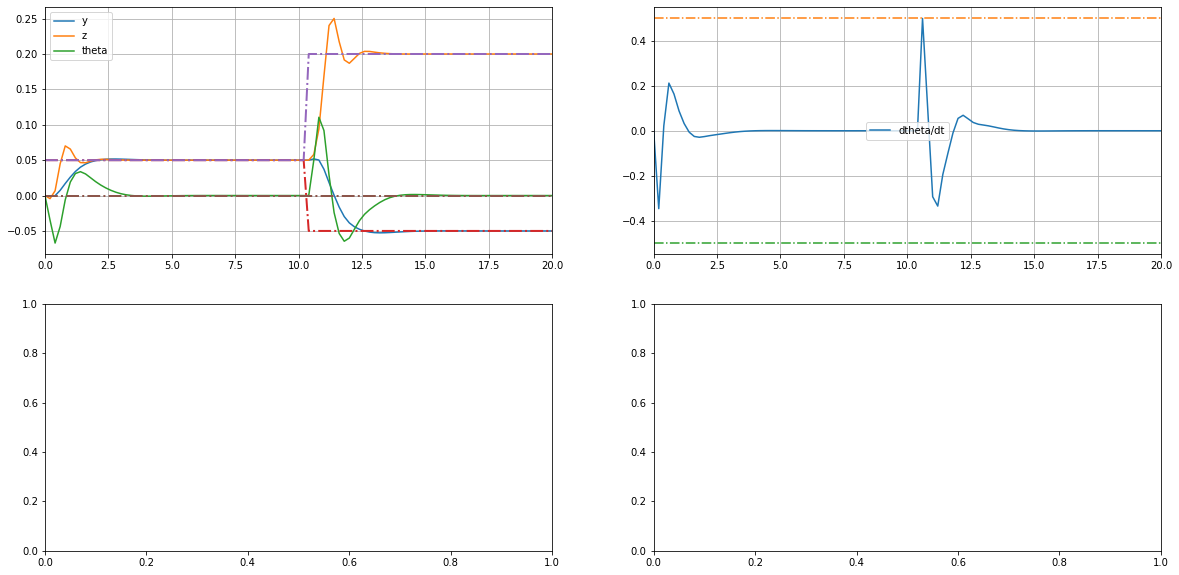

In [30]:
t = np.linspace(0, Nsim * M * dt, Nsim+1)
fig, ax = plt.subplots(figsize=(20,10), ncols=2, nrows=2)
ax[0,0].plot(t, Xcl[:,0], label='y');
ax[0,0].plot(t, Xcl[:,1], label='z');
ax[0,0].plot(t, Xcl[:,2], label='theta');
[ax[0,0].plot(t, Xref[:,i], '-.', linewidth=2) for i in range(3)];
ax[0,0].grid(True)
ax[0,0].legend();
ax[0,0].set_xlim([t.min(), t.max()])
#-----
ax[0,1].plot(t, Xcl[:,5], label='dtheta/dt');
ax[0,1].plot(t, np.ones(t.shape) * dtheta_dt_max, '-.')
ax[0,1].plot(t, -np.ones(t.shape) * dtheta_dt_max, '-.')
ax[0,1].grid(True)
ax[0,1].set_xlim([t.min(), t.max()])
ax[0,1].legend();
#-----

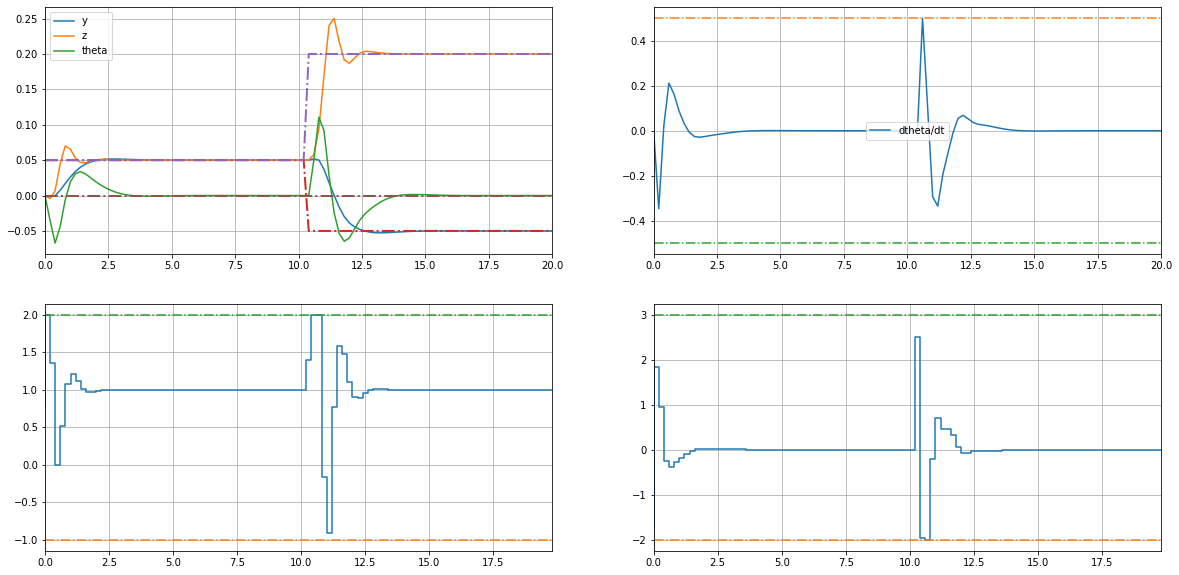

In [31]:
#-----
tu = t[0:-1]
ax[1,0].step(tu, Ucl[:,0])
ax[1,0].grid(True)
ax[1,0].set_xlim([tu.min(), tu.max()])
ax[1,0].plot(tu, np.ones(tu.shape)*umin[0], '-.');
ax[1,0].plot(tu, np.ones(tu.shape)*umax[0], '-.');
ax[1,0].set_xlim([tu.min(), tu.max()])
#-----
tu = t[0:-1]
ax[1,1].step(tu, Ucl[:,1])
ax[1,1].grid(True)
ax[1,1].set_xlim([tu.min(), tu.max()])
ax[1,1].plot(tu, np.ones(tu.shape)*umin[1], '-.');
ax[1,1].plot(tu, np.ones(tu.shape)*umax[1], '-.');
fig

## The CPU time per sampling period

(0.0, 100.0)

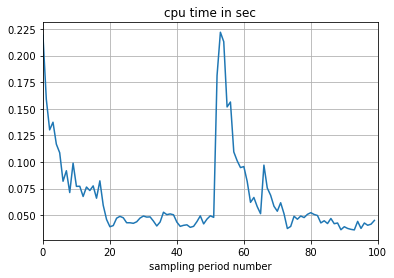

In [33]:
plt.plot(cpu)
plt.grid(True)
plt.xlabel('sampling period number')
plt.title('cpu time in sec')
plt.xlim([0, len(cpu)])

In [1]:
#%load_ext watermark
#print("----")
#%watermark -v -m -p IPython,ipywidgets,casadi,scipy,matplotlib
#print("----")
#%watermark -u -n -t -z